In [1]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *          

In [2]:
_clear = ['bingroup']

def _clear_prop(trace, prop):
    if hasattr(trace, prop):
        trace.update({prop: None})
        
def _clear_props(traces):
    for trace in traces:
        for prop in _clear:
            _clear_prop(trace, prop)

def left_right(left, right, width=700, height=250, **kwargs):
    fig = make_subplots(cols=2, **kwargs)
    fig.update_layout(width=width, height=height)
    
    t1 = next(left.select_traces())
    t2 = next(right.select_traces())
    _clear_props([t1, t2])
    fig.add_trace(t1, row=1, col=1)
    fig.add_trace(t2, row=1, col=2)
    return fig

def margin(fig, **kwargs):
    return fig.update_layout(margin=kwargs)

In [3]:
runners = pd.read_csv('data/cherryBlossomMen.csv')
dogs = pd.read_csv('data/akc.csv').dropna()

sfh_all = pd.read_csv('data/sfhousing.csv', error_bad_lines=False)

def subset(df):
    return df.loc[(df['price'] < 4_000_000) &
                  (df['bsqft'] < 12_000)]

def log_vals(sfh):
    return sfh.assign(log_price=np.log10(sfh['price']),
                      log_bsqft=np.log10(sfh['bsqft']),
                      log_lsqft=np.log10(sfh['lsqft']))

def clip_br(sfh):
    eight_up = sfh.loc[sfh['br'] >= 8, 'br'].unique()
    new_bed = sfh['br'].replace(eight_up, 8)
    return sfh.assign(br=new_bed)

sfh = (sfh_all
 .pipe(subset)
 .pipe(log_vals)
 .pipe(clip_br)
)

b'Skipping line 30550: expected 11 fields, saw 12\n'
b'Skipping line 343819: expected 11 fields, saw 12\n'


(sec:viz_smoothing)=
# Smoothing and Aggregating Data

When we have lots of data, we often don't want to plot all of the individual
data points.
The scatter plot below shows data from the [Cherry Blossom Run](https://www.cherryblossom.org/), an annual 10-mile race that takes place in April in Washington D.C. when the cherry trees are in bloom.
These data were scraped from the run's website and include official times and other information for all registered male runners from 1999 to 2012. 
We've plotted the runner's age on the x-axis and race time on the y-axis.

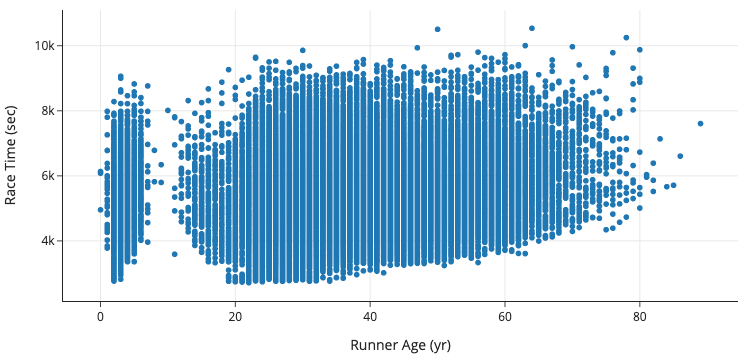

In [32]:
px.scatter(runners, x='age', y='time',
           labels={'age':"Runner Age (yr)", 'time':'Race Time (sec)'},
           width=350, height=250)

This scatter plot contains over 70,000 points. 
With so many points, many of them overlap with each other.
This is a common problem called *over-plotting*.
In this case, over-plotting prevents us from seeing how time and age are related.
About the only thing that we can see in this plot is a group of very young runners, which points to possible issues with data quality.
To address over-plotting, we use smoothing techniques that aggregate data before plotting.

## Smoothing Techniques to Uncover Shape

The histogram is a familiar type of plot that uses smoothing.
A histogram aggregates data values by putting points into bins and plotting one bar for each bin.
Smoothing here means that we can not differentiate the location of individual points in a bin: the points are smoothly allocated across their bins.
With histograms, the area of a bin corresponds to the percentage (or count or proportion) of points in the bin.
(Often the bins are equal in width and we take a shortcut to label the height of a bin as the proportion.)

The histogram below plots the distribution of lifespans for dog breeds.
Above the histogram is a rug plot that draws a single line for every data value.
We can see in the tallest bin that even a small amount of data can cause overplotting in the rug plot.
By smoothing out the points in the rug plot, the histogram reveals the general shape of the distribution.
In this case, we see that many breeds have a longevity of about 12 years.  For more on how to read and interpret
histograms, see {numref}`Chapter %s <ch:eda>`.

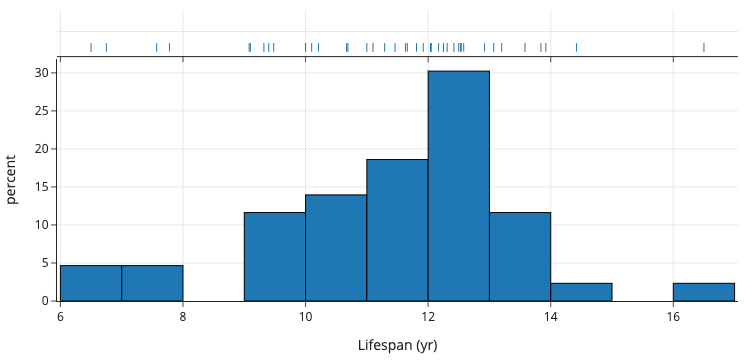

In [6]:
fig = px.histogram(dogs, x="longevity", marginal="rug", nbins=20,
                   labels={"longevity":"Lifespan (yr)"},
             histnorm='percent', width=350, height=250)
fig.data[0].marker.line =  dict( color = 'black',width = 1)
fig

Another common smoothing technique is *kernel density estimation* (KDE).
A KDE plot shows the distribution using a smooth curve rather than bars.
In the plot below, we show the same histogram of dog longevity with a KDE curve overlaid. The KDE curve shows a similar shape as the histogram.

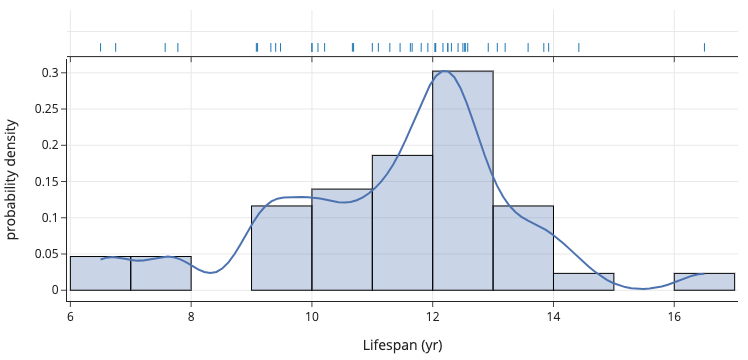

In [13]:
from scipy.stats import gaussian_kde

fig = px.histogram(dogs, x="longevity", marginal="rug",
                   histnorm='probability density', nbins=20,
                   labels={"longevity":"Lifespan (yr)"},
                   width=350, height=250)

fig.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

fig.data[0].marker.line =  dict( color = 'black',width = 1)

bandwidth = 0.2
xs = np.linspace(min(dogs['longevity']), max(dogs['longevity']), 100)
ys = gaussian_kde(dogs['longevity'], bandwidth)(xs)
curve = go.Scatter(x=xs, y=ys)

fig.add_trace(curve)
fig.update_traces(marker_color='rgb(76,114,176)',
                  selector=dict(type='scatter'))
fig.update_layout(showlegend=False)
fig.show()

It might come as a surprise to think of a histogram as a smoothing method. Both the KDE and histogram aim to help us see important features in the distribution of values. Similar smoothing techniques can be used with scatter plots. This is the topic of the next section.

## Smoothing Techniques to Uncover Relationships and Trends

We can find high density regions of a scatter plot by binning data, like in a histogram.
The plot below, remakes the earlier scatter plot of the Cherry Blossom race times against age. This plot uses square bins to aggregate points together, and 
then shades the rectangles based on how many points fall in them. (Note that we  drop the dubious young runners from this plot).

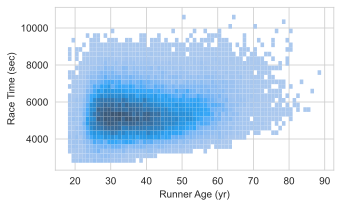

In [33]:
runnersOver17 = runners[runners["age"] > 17]

plt.figure(figsize=(5, 3))
fig = sns.histplot(runnersOver17, x='age', y='time', binwidth=[1, 250])
plt.xlabel("Runner Age (yr)")
plt.ylabel("Race Time (sec)")
plt.show(fig)

Notice the high density region in the 25 to 40 age group signified by the dark region in the plot. 
The plot shows us that many of the runners in this age range complete the race in around 5000 seconds (about 80 minutes). We can also see upward curvature in the region corresponding to the 40 to 60 year age group, which indicates these runners are generally slower than those in the 25 to 40 age group.

Kernel density estimation also works in two dimensions.
When we use KDE in two dimensions, we typically plot the contours of the resulting three-dimensional shape, and we read the plot like a topographical map.

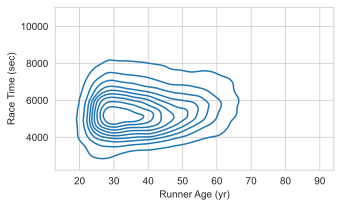

In [34]:
# Takes a while to run!
plt.figure(figsize=(5, 3))
fig = sns.kdeplot(data=runnersOver17, x='age', y='time')
plt.xlabel("Runner Age (yr)")
plt.ylabel("Race Time (sec)")
plt.show(fig)

This two-dimensional KDE gives similar insights as the shaded squares. We see a high concentration of runners in the 25 to 40 age group and these runners have times that appear to be roughly 5000 seconds.
Smoothing lets us get a better picture when there's lots of data because it can reveal the locations of highly concentrated data values and the shape of these high concentration regions. These regions may be impossible to otherwise see. 

Another smoothing approach that is often more informative, smooths the y-values for points with a similar x-value. To explain, let's group together runners with similar ages; we use five-year increments: 20-25, 25-30, 30-35, etc. Then, for each 5-year bin of runners, we average their race times, plot the average time for each group, and connect the points to form a "curve".

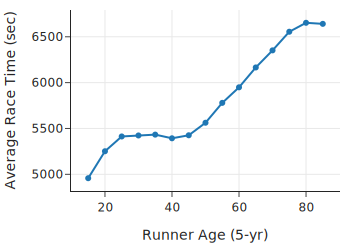

In [35]:
times = (
    runnersOver17.assign(age_5yr=runnersOver17['age'] // 5 * 5)
    .groupby('age_5yr')['time'].mean().reset_index()
)

px.line(times, x='age_5yr', y='time',
        labels={'time':"Average Race Time (sec)", 'age_5yr':"Runner Age (5-yr)"},
        markers=True, 
        width=350, height=250)

This plot shows once again that runners in the 25 to 40 year age range have typical run times of about 5400 seconds. It also show that older runners took longer to complete the race on average (not really a surprise, but it wasn't nearly as evident in the earlier plots). The dip in times for runners under 20 and the flattening of the curve at 80 may be simply the result of fewer and fitter runners in these groups. Another smoothing technique uses kernel smoothing similar to the KDE. We don't go into the details here. 

Whether using a binning or kernel smoothing technique, these methods rely on a tuning parameter that specifies the width of the bin or the spread of the kernel, and we often need to specify this parameter when making a histogram, KDE, or smooth curve. This is the topic of the next section.  

## Smoothing Techniques Need Tuning

Now that we've seen how smoothing is useful for plotting, we turn to the issue of tuning. 
For histograms, the width of the bins or, for equal-width bins, the number of bins affect the look of the histogram. 
The left histogram of longevity below has a few wide bins, and the right histogram has many narrow bins. In both cases, it's hard to see the shape of the distribution.
With a few wide bins, we have over-smoothed the distribution, which makes it impossible to discern modes and tails. On the other hand, too many bins, gives a plot that's little better than a rug plot.
KDE plots have a parameter called the "bandwidth" that works similarly to the bin width of a histogram.

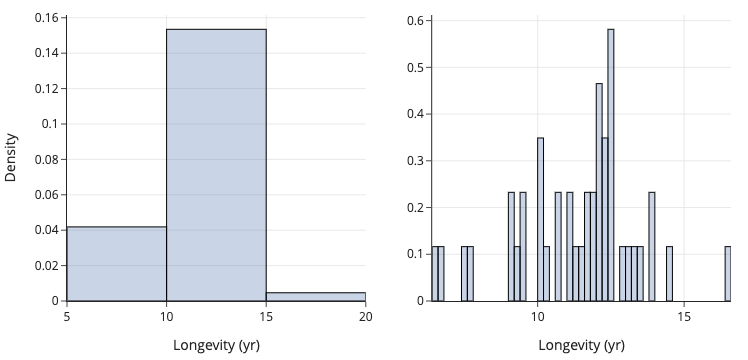

In [26]:
f1 = px.histogram(dogs, x="longevity", nbins=3, histnorm='probability density',
             width=350, height=250)

f1.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

f1.data[0].marker.line =  dict( color = 'black',width = 1)

#bandwidth = 0.5
xs = np.linspace(min(dogs['longevity']), max(dogs['longevity']), 100)
ys = gaussian_kde(dogs['longevity'])(xs)
curve = go.Scatter(x=xs, y=ys)
f1.add_trace(curve)

f2 = px.histogram(dogs, x="longevity", nbins=100, histnorm='probability density',
             width=350, height=250)
f2.update_traces(marker_color='rgba(76,114,176,0.3)',
                  selector=dict(type='histogram'))

f2.data[0].marker.line =  dict( color = 'black',width = 1)


fig = left_right(f1, f2, height=250)
fig.update_xaxes(title_text='Longevity (yr)', row=1, col=1)
fig.update_xaxes(title_text='Longevity (yr)', row=1, col=2)
fig.update_yaxes(title_text='Density', row=1, col=1)
fig.show()

Most histogram and KDE software automatically choose the bin width for the histogram and band width  for the kernel. However, these parameters often need a bit of fiddling to create the most useful plot.  When you create visualizations that rely on tuning parameters, it's important to try a few different values before settling on one.

A different approach to data reduction is to examine quantiles. This is the topic of the next section. 

## Reducing Distributions to Quantiles

We found in {numref}`Chapter %s <ch:eda>` that while box plots aren't as informative as histograms, they can be useful when comparing the distributions of many groups at once. A box plot reduces the data to a few essential features based on the data quartiles. More generally, quantiles (the lower quartile, median, and upper quartile are the 25th, 50th, and 75th quantiles) can provide a useful reduction in the data when comparing distributions.

When two distributions are roughly similar in shape, it can be hard to compare them with histograms.
For instance, the histograms below show the price distributions for two- and four-bedroom houses in the SF housing data. 
The distributions look roughly similar in shape. But, a plot of their quantiles handily compares the distributions' center, spread, and tails.

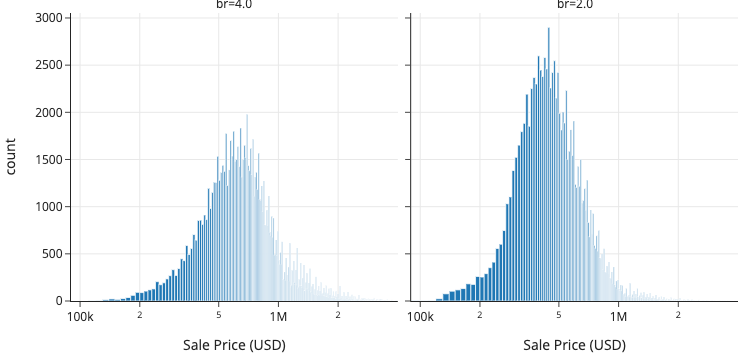

In [27]:
px.histogram(sfh.query('br in [2, 4]'),
             x='price', log_x=True, facet_col='br', 
             labels={'price':"Sale Price (USD)"},
             width=700, height=250)

We can compare quantiles with a *quantile-quantile* plot, called q-q plot for short. To make this plot, we first compute percentiles (also called quantiles) for both distributions. Then, we plot the matching percentiles on a scatter plot. We usually also show the reference line y = x to help with the comparison.

In [28]:
br2 = sfh.query('br == 2')
br4 = sfh.query('br == 4')
percs = np.arange(1, 100, 1)
perc2 = np.percentile(br2['price'], percs, interpolation='lower')
perc4 = np.percentile(br4['price'], percs, interpolation='lower')
perc_sfh = pd.DataFrame({'percentile': percs, 'br2': perc2, 'br4': perc4})
perc_sfh

percentile       br2       br4
0            1  1.50e+05  2.05e+05
1            2  1.82e+05  2.50e+05
2            3  2.03e+05  2.75e+05
..         ...       ...       ...
96          97  1.04e+06  1.75e+06
97          98  1.20e+06  1.95e+06
98          99  1.44e+06  2.34e+06

[99 rows x 3 columns]

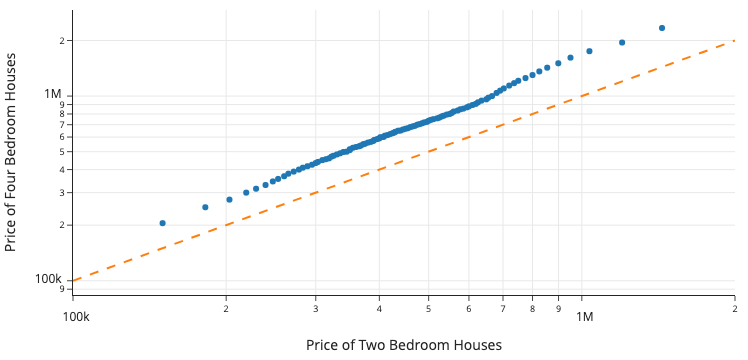

In [29]:
fig = px.scatter(perc_sfh, x='br2', y='br4', log_x=True, log_y=True, 
                 labels={'br2': 'Price of Two Bedroom Houses',
                         'br4': 'Price of Four Bedroom Houses'},
                 width=350, height=250)

fig.add_trace(
    go.Scatter(x=[1e5, 2e6], y=[1e5, 2e6], 
               mode='lines', line=dict(dash='dash'))
)
fig.update_layout(showlegend=False)
fig

When the quantile points fall along a line, the variables have similarly shaped distributions.
Lines parallel to the reference indicate a difference in center; lines with slopes other than 1 indicate a difference in spread, and curvature indicates a difference in shape. 
From the q-q plot above, we see that the distribution of price for four-bedroom houses is similar in shape to the two-bedroom  distribution, except for a shift of about $\$100K$ and a slightly longer right tail (indicated by the upward bend for large values). 
Reading a q-q plot takes practice. Once you get the hang of it though, it can be a handy way to compare distributions. Notice that the housing data have over 100,000 observations, and the q-q plot has reduced the data to 99 percentiles. 
This data reduction is quite useful. However, we don't always want to use smoothers. This is the topic of the next section.

## When Not to Smooth

Smoothing and aggregating can help us see important features and relationships, but when we have only a handful of observations, smoothing techniques can be misleading.  With just a few observations, we prefer rug plots over histograms, box plots, and density curves, and we use scatter plots rather than smooth curves and density contours. This may seem obvious, but when we have a large amount of data, the amount of data in a subgroup can quickly dwindle. This phenomeon is an example of the "curse of dimensionality".

One of the most common misuses of smoothing happens with box plots. As an example, below is a collection of seven box plots of longevity, one for each type of dog breed. Some of these boxplots have as few as two or three observations.  

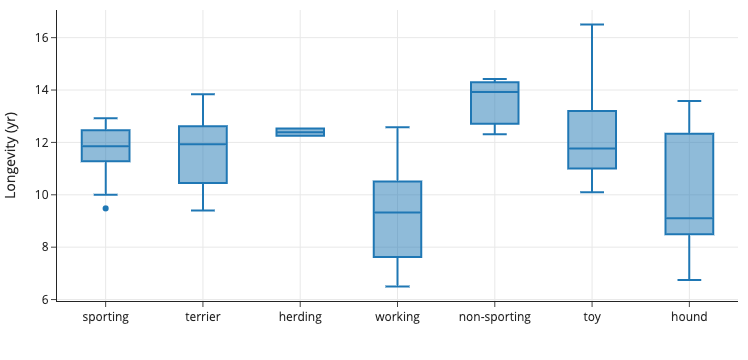

In [30]:
px.box(dogs, x='group', y='longevity', 
       labels={'group':"", 'longevity':"Longevity (yr)"},
       width=500, height=250)

The strip plot below is a preferable visualization. We can still compare the groups, but we also see the exact values in each group. Now we can tell that there are only three breeds in the non-sporting group; the impression of a skewed distribution, based on the box plot, read too much into the shape of the box.

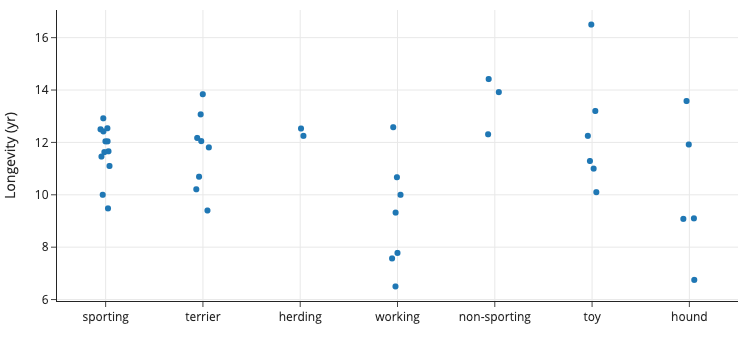

In [31]:
px.strip(dogs, x="group", y="longevity", 
         labels={'group':"", 'longevity':"Longevity (yr)"},
         width=400, height=250)

This section introduced the problem of over-plotting, where we have overlapping points because of a large dataset. To address this issue, we introduced smoothing techniques that aggregate data.
We saw two common examples of smoothing: binning and kernel smoothing, and applied them in the one- and two-dimensional settings. In one-dimension, these are histograms and kernel density curves, respectively, and they both help us see the shape of a distribution. 
In two dimensions, we found it useful to smooth y-values while keeping x-values fixed in order to visualize trends.
We addressed the need to tune the smoothing amount to get more informative histograms and density curves, and we cautioned against smoothing with too few data. 

There are many other ways to reduce over-plotting in scatter plots.
For instance, we can make the dots partially transparent so overlapping points appear darker.
If many observations have the same values (e.g., when measurements are rounded to the nearest inch),
then we can add a small amount of random noise to the values to reduce the amount of over-plotting. 
This procedure is called *jittering*, and it is used in the strip plot of longevity.
Transparency and jittering are convenient for medium-sized data.
However, they don't work very well for large datasets since they still plot all the points in the data.

The quantile-quantile plot we introduced offers one way to compare distributions, another is to use side-by-side box plots and yet another is to overlay KDE curves in the same plot. We often aim to compare distributions and relationships across subsets (or groups) of data, and in the next section, we discuss several design principles that facilitate meaningful comparisons for a variety of plot types.